In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib.image as img

In [2]:
mat = loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']
X.shape, y.shape

((5000, 400), (5000, 1))

In [3]:
Theta = loadmat('ex4weights.mat')
Theta1 = Theta['Theta1']
Theta2 = Theta['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

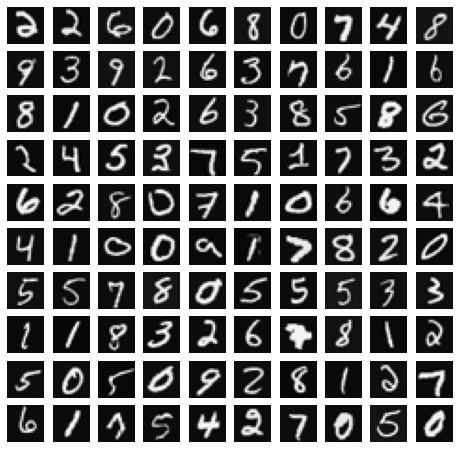

In [4]:
fig, axis = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        axis[i, j].imshow(X[np.random.randint(0, 5001), :].reshape(20, 20, order='F'), cmap='gray')
        axis[i, j].axis('off')

**SIGMOID GRADIENT**

σ'(z) = σ(z) * (1 - σ(z))

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def sigmoidGradient(z):
    return (sigmoid(z) * (1-sigmoid(z)))

**Neural Networks cost function**

$J(\Theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\Theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\Theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2]$


In [6]:
def costFunction(nn_params, X, y, input_layer_size, hidden_layer_size, num_labels, Lambda):
    
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = nn_params[((input_layer_size+1) * hidden_layer_size):].reshape(num_labels, hidden_layer_size+1)
    
    #Feedforward and Cost Function
    m = X.shape[0]
    X = np.column_stack((np.ones((m ,1)), X)) #5000 x 401
    a2 = sigmoid(X@Theta1.T) #5000 x 25
    a2 = np.hstack((np.ones((m, 1)), a2)) #5000 x 26
    a3 = sigmoid(a2@Theta2.T) #5000 x 10
    
    y_matrix = np.zeros((m, num_labels)) #5000 x 10
    for i in range(1, num_labels+1):
        y_matrix[:, i-1][:, np.newaxis] = np.where(y==i, 1, 0)
        
    J = np.sum(np.sum( -y_matrix * np.log(a3) - (1 - y_matrix) * np.log(1 - a3) ))  
    reg = Lambda/(2*m) * (np.sum(Theta1[:, 1:]**2) + np.sum(Theta2[:, 1:]**2))
    
    J = (1/m) * J
    reg_J = J + reg
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi = X[i, :] #1 x 401
        a2i = a2[i, :] #1 x 26
        a3i = a3[i, :] #1 x 10
        
        d3 = a3i - y_matrix[i, :]
        d2 = (Theta2.T @ d3.T) * sigmoidGradient(np.hstack((1, xi @ Theta1.T)))
        
        grad1 = grad1 + d2[1:][:, np.newaxis] @ xi[:, np.newaxis].T
        grad2 = grad2 + d3.T[:, np.newaxis] @ a2i[:, np.newaxis].T
    
    grad1 = 1/m * grad1
    grad2 = 1/m * grad2     
    grad1_reg = grad1 + Lambda/m * np.hstack((np.zeros((Theta1.shape[0], 1)), Theta1[:, 1:]))
    grad2_reg = grad2 + Lambda/m * np.hstack((np.zeros((Theta2.shape[0], 1)), Theta2[:, 1:]))
        
    return J, grad1, grad2, reg_J, grad1_reg, grad2_reg        

In [7]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

nn_params = np.append(Theta1.flatten(), Theta2.flatten())
J, reg_J = costFunction(nn_params, X, y, input_layer_size, hidden_layer_size, num_labels, 1)[0:4:3]

print(f"Cost at parameters(non-regularized): {J}\nCost at parameters(Regularized): {reg_J}")

Cost at parameters(non-regularized): 0.2876291651613189
Cost at parameters(Regularized): 0.38376985909092365


**Random initialization**

Select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init} , \epsilon_{init}]$

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network

$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$


In [8]:
def randomInitailization(L_in, L_out):
    epi = np.sqrt(6)/np.sqrt(L_in+L_out)
    W = np.random.rand(L_out, L_in+1) * 2*epi - epi
    return W

In [9]:
initial_Theta1 = randomInitailization(input_layer_size, hidden_layer_size)
initial_Theta2 = randomInitailization(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(), initial_Theta2.flatten())

In [10]:
def gradientDescent(initial_nn_params, X, y, input_layer_size, hidden_layer_size, num_labels, alpha, num_iters, Lambda):
    
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size+1) * hidden_layer_size):].reshape(num_labels, hidden_layer_size+1)
    
    m = len(y)
    J_history = []
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(), Theta2.flatten())
        cost, grad1, grad2 = costFunction(nn_params, X, y, input_layer_size, hidden_layer_size, num_labels, Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    nn_params_final = np.append(Theta1.flatten(), Theta2.flatten())
    
    return nn_params_final, J_history  

In [11]:
nn_params, J_history = gradientDescent(initial_nn_params, X, y, input_layer_size, hidden_layer_size, num_labels, 0.8, 800, 1)
Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1)
Theta2 = nn_params[((input_layer_size+1) * hidden_layer_size):].reshape(num_labels, hidden_layer_size+1)

In [12]:
initial_nn_params.shape

(10285,)

In [17]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    X = np.hstack((np.ones((m, 1)), X))
    a2 = sigmoid(X @ Theta1.T)
    a2 = np.hstack((np.ones((m, 1)), a2))
    a3 = sigmoid(a2 @ Theta2.T)
    return np.argmax(a3, axis=1)+1

In [21]:
pred = predict(Theta1, Theta2, X)
print(f"Accuracy = {np.mean(pred[:, np.newaxis]==y) * 100}%")

Accuracy = 94.58%
